# Categorical VAE with Gumbel-Softmax (Run in tensorflow 2.0)

Partial implementation of the paper [Categorical Reparameterization with Gumbel-Softmax](https://arxiv.org/abs/1611.01144) 

https://blog.evjang.com/2016/11/tutorial-categorical-variational.html

A categorical VAE with discrete latent variables. Tensorflow version is 0.10.0.

# 1. Imports and Helper Functions

In [1]:
# import tensorflow as tf
# from tensorflow.examples.tutorials.mnist import input_data
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()  # disable TensorFlow 2.x，enable 1.x

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# slim=tf.contrib.slim
import tf_slim as slim
# Bernoulli = tf.contrib.distributions.Bernoulli

import tensorflow_probability as tfp

Bernoulli = tfp.distributions.Bernoulli

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def sample_gumbel(shape, eps=1e-20): 
  """Sample from Gumbel(0, 1)"""
  U = tf.random_uniform(shape,minval=0,maxval=1)
  return -tf.log(-tf.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature): 
  """ Draw a sample from the Gumbel-Softmax distribution"""
  y = logits + sample_gumbel(tf.shape(logits))
  return tf.nn.softmax( y / temperature)

def gumbel_softmax(logits, temperature, hard=False):
  """Sample from the Gumbel-Softmax distribution and optionally discretize.
  Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
  Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
  """
  y = gumbel_softmax_sample(logits, temperature)
  if hard:
    k = tf.shape(logits)[-1]
    #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
    y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keep_dims=True)),y.dtype)
    y = tf.stop_gradient(y_hard - y) + y
  return y

# 2. Build Model

In [3]:
K=10 # number of classes
N=30 # number of categorical distributions

In [4]:
# input image x (shape=(batch_size,784))
x = tf.placeholder(tf.float32,[None,784])
# variational posterior q(y|x), i.e. the encoder (shape=(batch_size,200))
net = slim.stack(x,slim.fully_connected,[512,256])
# unnormalized logits for N separate K-categorical distributions (shape=(batch_size*N,K))
logits_y = tf.reshape(slim.fully_connected(net,K*N,activation_fn=None),[-1,K])
q_y = tf.nn.softmax(logits_y)
log_q_y = tf.log(q_y+1e-20)
# temperature
tau = tf.Variable(5.0,name="temperature")
# sample and reshape back (shape=(batch_size,N,K))
# set hard=True for ST Gumbel-Softmax
y = tf.reshape(gumbel_softmax(logits_y,tau,hard=False),[-1,N,K])
# generative model p(x|y), i.e. the decoder (shape=(batch_size,200))
net = slim.stack(slim.flatten(y),slim.fully_connected,[256,512])
logits_x = slim.fully_connected(net,784,activation_fn=None)
# (shape=(batch_size,784))
p_x = Bernoulli(logits=logits_x)

/opt/anaconda3/lib/python3.11/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/opt/anaconda3/lib/python3.11/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


In [5]:
# loss and train ops
kl_tmp = tf.reshape(q_y*(log_q_y-tf.log(1.0/K)),[-1,N,K])
KL = tf.reduce_sum(kl_tmp,[1,2])
elbo=tf.reduce_sum(p_x.log_prob(x),1) - KL
# Notes by Yafei Zhao: 
#   Bernoulli.log_prob() uses tf.nn.sigmoid_cross_entropy_with_logits, which supports soft label (when x is not 0 or 1);
#   When x is soft lable, p_x.log_prob(x) returns the cross entropy loss between logits_x (will be convert into probs) and x.
# Refer to:
#     1) tf.contrib.distributions.Bernoulli (in tensorflow 0.10.0): 
#         https://github.com/tensorflow/tensorflow/blob/v0.10.0/tensorflow/contrib/distributions/python/ops/bernoulli.py

#         class Bernoulli(distribution.Distribution):
#         """Bernoulli distribution.

#         The Bernoulli distribution is parameterized by p, the probability of a
#         positive event.
#         """

#         def __init__(self,
#                     logits=None,
#                     p=None,
#                     dtype=dtypes.int32,
#                     validate_args=True,
#                     allow_nan_stats=False,
#                     name="Bernoulli"):
#             """Construct Bernoulli distributions.

#             Args:
#             logits: An N-D `Tensor` representing the log-odds
#                 of a positive event. Each entry in the `Tensor` parametrizes
#                 an independent Bernoulli distribution where the probability of an event
#                 is sigmoid(logits).
#             p: An N-D `Tensor` representing the probability of a positive
#                 event. Each entry in the `Tensor` parameterizes an independent
#                 Bernoulli distribution.
#             dtype: dtype for samples.
#             validate_args: Whether to assert that `0 <= p <= 1`. If not validate_args,
#             `log_pmf` may return nans.
#             allow_nan_stats:  Boolean, default `False`.  If `False`, raise an
#                 exception if a statistic (e.g. mean/mode/etc...) is undefined for any
#                 batch member.  If `True`, batch members with valid parameters leading to
#                 undefined statistics will return NaN for this statistic.
#             name: A name for this distribution.

#             Raises:
#             ValueError: If p and logits are passed, or if neither are passed.
#             """
#             ...
            
#         def log_prob(self, event, name="log_prob"):
#             """Log of the probability mass function.

#             Args:
#             event: `int32` or `int64` binary Tensor.
#             name: A name for this operation (optional).

#             Returns:
#             The log-probabilities of the events.
#             """
#             # TODO(jaana): The current sigmoid_cross_entropy_with_logits has
#             # inconsistent  behavior for logits = inf/-inf.
#             with ops.name_scope(self.name):
#             with ops.op_scope([self.logits, event], name):
#                 event = ops.convert_to_tensor(event, name="event")
#                 event = math_ops.cast(event, self.logits.dtype)
#                 logits = self.logits
#                 # sigmoid_cross_entropy_with_logits doesn't broadcast shape,
#                 # so we do this here.
#                 # TODO(b/30637701): Check dynamic shape, and don't broadcast if the
#                 # dynamic shapes are the same.
#                 if (not event.get_shape().is_fully_defined() or
#                     not logits.get_shape().is_fully_defined() or
#                     event.get_shape() != logits.get_shape()):
#                 logits = array_ops.ones_like(event) * logits
#                 event = array_ops.ones_like(logits) * event
#                 return -nn.sigmoid_cross_entropy_with_logits(logits, event)
#             ...
#     2) tf.nn.sigmoid_cross_entropy_with_logits (in tensorflow 0.10.0):
#         https://github.com/tensorflow/tensorflow/blob/v0.10.0/tensorflow/g3doc/api_docs/python/functions_and_classes/shard5/tf.nn.sigmoid_cross_entropy_with_logits.md
#         tf.nn.sigmoid_cross_entropy_with_logits(logits, targets, name=None) {#sigmoid_cross_entropy_with_logits}
#         Computes sigmoid cross entropy given logits.

#         Measures the probability error in discrete classification tasks in which each class is independent and not mutually exclusive. For instance, one could perform multilabel classification where a picture can contain both an elephant and a dog at the same time.

#         For brevity, let x = logits, z = targets. The logistic loss is

#         z * -log(sigmoid(x)) + (1 - z) * -log(1 - sigmoid(x))
#         = z * -log(1 / (1 + exp(-x))) + (1 - z) * -log(exp(-x) / (1 + exp(-x)))
#         = z * log(1 + exp(-x)) + (1 - z) * (-log(exp(-x)) + log(1 + exp(-x)))
#         = z * log(1 + exp(-x)) + (1 - z) * (x + log(1 + exp(-x))
#         = (1 - z) * x + log(1 + exp(-x))
#         = x - x * z + log(1 + exp(-x))

#     3) tfp.distributions.Bernoulli (in tensorflow_probability v0.24.0):
#         https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Bernoulli
#         https://github.com/tensorflow/probability/blob/v0.24.0/tensorflow_probability/python/distributions/bernoulli.py
#         class Bernoulli(
#             distribution.DiscreteDistributionMixin,
#             distribution.AutoCompositeTensorDistribution):
#         """Bernoulli distribution.

#         The Bernoulli distribution with `probs` parameter, i.e., the probability of a
#         `1` outcome (vs a `0` outcome).
#         """

#         def __init__(self,
#                     logits=None,
#                     probs=None,
#                     dtype=tf.int32,
#                     validate_args=False,
#                     allow_nan_stats=True,
#                     name='Bernoulli'):
#             """Construct Bernoulli distributions.

#             Args:
#             logits: An N-D `Tensor` representing the log-odds of a `1` event. Each
#                 entry in the `Tensor` parameterizes an independent Bernoulli
#                 distribution where the probability of an event is sigmoid(logits). Only
#                 one of `logits` or `probs` should be passed in.
#             probs: An N-D `Tensor` representing the probability of a `1`
#                 event. Each entry in the `Tensor` parameterizes an independent
#                 Bernoulli distribution. Only one of `logits` or `probs` should be passed
#                 in.
#             dtype: The type of the event samples. Default: `int32`.
#             validate_args: Python `bool`, default `False`. When `True` distribution
#                 parameters are checked for validity despite possibly degrading runtime
#                 performance. When `False` invalid inputs may silently render incorrect
#                 outputs.
#             allow_nan_stats: Python `bool`, default `True`. When `True`,
#                 statistics (e.g., mean, mode, variance) use the value "`NaN`" to
#                 indicate the result is undefined. When `False`, an exception is raised
#                 if one or more of the statistic's batch members are undefined.
#             name: Python `str` name prefixed to Ops created by this class.

#             Raises:
#             ValueError: If p and logits are passed, or if neither are passed.
#             """

#             ...
        
#           def _log_prob(self, event):
#             log_probs0, log_probs1 = self._outcome_log_probs()
#             event = tf.cast(event, log_probs0.dtype)
#             return (tf.math.multiply_no_nan(log_probs0, 1 - event) +
#                     tf.math.multiply_no_nan(log_probs1, event))

            

#             """
#                 For brevity, let x = Bernoulli.logits, z = event. The logistic loss is

#                 z * -log(sigmoid(x)) + (1 - z) * -log(1 - sigmoid(x))
#                 = z * -log(1 / (1 + exp(-x))) + (1 - z) * -log(exp(-x) / (1 + exp(-x)))
#                 = z * log(1 + exp(-x)) + (1 - z) * (-log(exp(-x)) + log(1 + exp(-x)))
#                 = z * log(1 + exp(-x)) + (1 - z) * (x + log(1 + exp(-x))
#                 = (1 - z) * x + log(1 + exp(-x))
#                 = x - x * z + log(1 + exp(-x))
#             """
            

In [6]:
loss=tf.reduce_mean(-elbo)
lr=tf.constant(0.001)
train_op=tf.train.AdamOptimizer(learning_rate=lr).minimize(loss,var_list=slim.get_model_variables())
init_op=tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


# 3. Train

In [7]:
# get data
# from tensorflow.examples.tutorials.mnist import input_data
# data = input_data.read_data_sets('/tmp/', one_hot=True).train 

from tensorflow import keras

# load MNIST
(x_train, y_train), _ = keras.datasets.mnist.load_data()
print("Training data x_train shape:", x_train.shape)
print("Training data y_train shape:", y_train.shape)

# print("Training data x_train[0]:", x_train[0])
print("Training data y_train[0]:", y_train[0])

# preprocess
# x_train = x_train.astype('float32') / 255.0
y_train = keras.utils.to_categorical(y_train, num_classes=10)

print("Training data x_train shape:", x_train.shape)
print("Training data y_train shape:", y_train.shape)

# print("Training data x_train[0]:", x_train[0])
print("Training data y_train[0]:", y_train[0])


Training data x_train shape: (60000, 28, 28)
Training data y_train shape: (60000,)
Training data y_train[0]: 5
Training data x_train shape: (60000, 28, 28)
Training data y_train shape: (60000, 10)
Training data y_train[0]: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [8]:
from tensorflow.python.framework import dtypes

# copied from: https://github.com/tensorflow/tensorflow/blob/v0.10.0/tensorflow/contrib/learn/python/learn/datasets/mnist.py
class DataSet(object):

  def __init__(self,
               images,
               labels,
               fake_data=False,
               one_hot=False,
               dtype=dtypes.float32,
               reshape=True):
    """Construct a DataSet.
    one_hot arg is used only if fake_data is true.  `dtype` can be either
    `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
    `[0, 1]`.
    """
    dtype = dtypes.as_dtype(dtype).base_dtype
    if dtype not in (dtypes.uint8, dtypes.float32):
      raise TypeError('Invalid image dtype %r, expected uint8 or float32' %
                      dtype)
    if fake_data:
      self._num_examples = 10000
      self.one_hot = one_hot
    else:
      assert images.shape[0] == labels.shape[0], (
          'images.shape: %s labels.shape: %s' % (images.shape, labels.shape))
      self._num_examples = images.shape[0]

      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
      if reshape:
        # assert images.shape[3] == 1
        images = images.reshape(images.shape[0],
                                images.shape[1] * images.shape[2])
      if dtype == dtypes.float32:
        # Convert from [0, 255] -> [0.0, 1.0].
        images = images.astype(np.float32)
        images = np.multiply(images, 1.0 / 255.0)
    self._images = images
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
    return self._images

  @property
  def labels(self):
    return self._labels

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_completed(self):
    return self._epochs_completed

  def next_batch(self, batch_size, fake_data=False):
    """Return the next `batch_size` examples from this data set."""
    if fake_data:
      fake_image = [1] * 784
      if self.one_hot:
        fake_label = [1] + [0] * 9
      else:
        fake_label = 0
      return [fake_image for _ in range(batch_size)], [
          fake_label for _ in range(batch_size)
      ]
    start = self._index_in_epoch
    self._index_in_epoch += batch_size
    if self._index_in_epoch > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Shuffle the data
      perm = np.arange(self._num_examples)
      np.random.shuffle(perm)
      self._images = self._images[perm]
      self._labels = self._labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size
      assert batch_size <= self._num_examples
    end = self._index_in_epoch
    return self._images[start:end], self._labels[start:end]

data = DataSet(x_train, y_train, one_hot=True)

In [9]:
BATCH_SIZE=100
NUM_ITERS=50000
tau0=1.0 # initial temperature
np_temp=tau0
np_lr=0.001
ANNEAL_RATE=0.00003
MIN_TEMP=0.5

In [10]:
dat=[]
sess=tf.InteractiveSession()
sess.run(init_op)
for i in range(1,NUM_ITERS):
  np_x,np_y=data.next_batch(BATCH_SIZE)
  # np_x = np_x.reshape(-1,784)
  _,np_loss=sess.run([train_op,loss],{
      x:np_x,
      tau:np_temp,
      lr:np_lr
    })
  if i % 100 == 1:
    dat.append([i,np_temp,np_loss])
  if i % 1000 == 1:
    np_temp=np.maximum(tau0*np.exp(-ANNEAL_RATE*i),MIN_TEMP)
    np_lr*=0.9
  if i % 5000 == 1:
    print('Step %d, ELBO: %0.3f' % (i,-np_loss))

Step 1, ELBO: -544.636
Step 5001, ELBO: -93.502
Step 10001, ELBO: -84.937
Step 15001, ELBO: -85.496
Step 20001, ELBO: -81.348
Step 25001, ELBO: -83.378
Step 30001, ELBO: -84.808
Step 35001, ELBO: -83.414
Step 40001, ELBO: -75.468
Step 45001, ELBO: -83.930


## save to animation

In [11]:
np_x1,_=data.next_batch(100)
# np_x1 = np_x1.reshape(-1, 784)
np_x2,np_y1 = sess.run([p_x.mean(),y],{x:np_x1})

In [12]:
import matplotlib.animation as animation

In [13]:
def save_anim(data,figsize,filename):
  fig=plt.figure(figsize=(figsize[1]/10.0,figsize[0]/10.0))
  im = plt.imshow(data[0].reshape(figsize),cmap=plt.cm.gray,interpolation='none')
  plt.gca().set_axis_off()
  #fig.tight_layout()
  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
  def updatefig(t):
    im.set_array(data[t].reshape(figsize))
    return im,
  anim=animation.FuncAnimation(fig, updatefig, frames=100, interval=50, blit=True, repeat=True)
  Writer = animation.writers['ffmpeg']
  writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)
  anim.save(filename, writer=writer)
  return

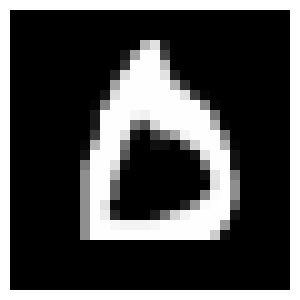

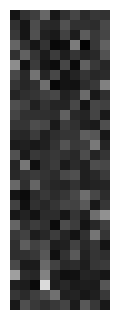

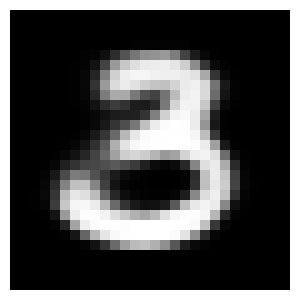

In [14]:
save_anim(np_x1,(28,28),'x0.gif')
save_anim(np_y1,(N,K),'y.gif')
save_anim(np_x2,(28,28),'x1.gif')

# 4. Plot Training Curves

In [15]:
dat=np.array(dat).T

Text(0, 0.5, '-ELBO')

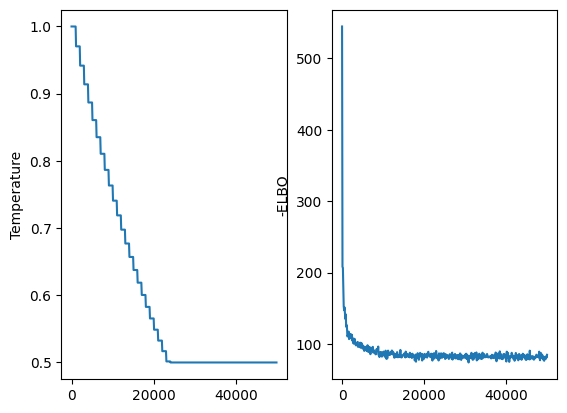

In [16]:
f,axarr=plt.subplots(1,2)
axarr[0].plot(dat[0],dat[1])
axarr[0].set_ylabel('Temperature')
axarr[1].plot(dat[0],dat[2])
axarr[1].set_ylabel('-ELBO')

# 5. Unconditional Generation

This consists of sampling from the prior $p_\theta(y)$ and passing it through the generative model.

In [17]:
M=100*N
np_y = np.zeros((M,K))
np_y[range(M),np.random.choice(K,M)] = 1
np_y = np.reshape(np_y,[100,N,K])

In [18]:
x_p=p_x.mean()
np_x= sess.run(x_p,{y:np_y})

In [19]:
np_y = np_y.reshape((10,10,N,K))
np_y = np.concatenate(np.split(np_y,10,axis=0),axis=3)
np_y = np.concatenate(np.split(np_y,10,axis=1),axis=2)
y_img = np.squeeze(np_y)

In [20]:
np_x = np_x.reshape((10,10,28,28))
# split into 10 (1,10,28,28) images, concat along columns -> 1,10,28,280
np_x = np.concatenate(np.split(np_x,10,axis=0),axis=3)
# split into 10 (1,1,28,280) images, concat along rows -> 1,1,280,280
np_x = np.concatenate(np.split(np_x,10,axis=1),axis=2)
x_img = np.squeeze(np_x)

Text(0.5, 1.0, 'Generated Images')

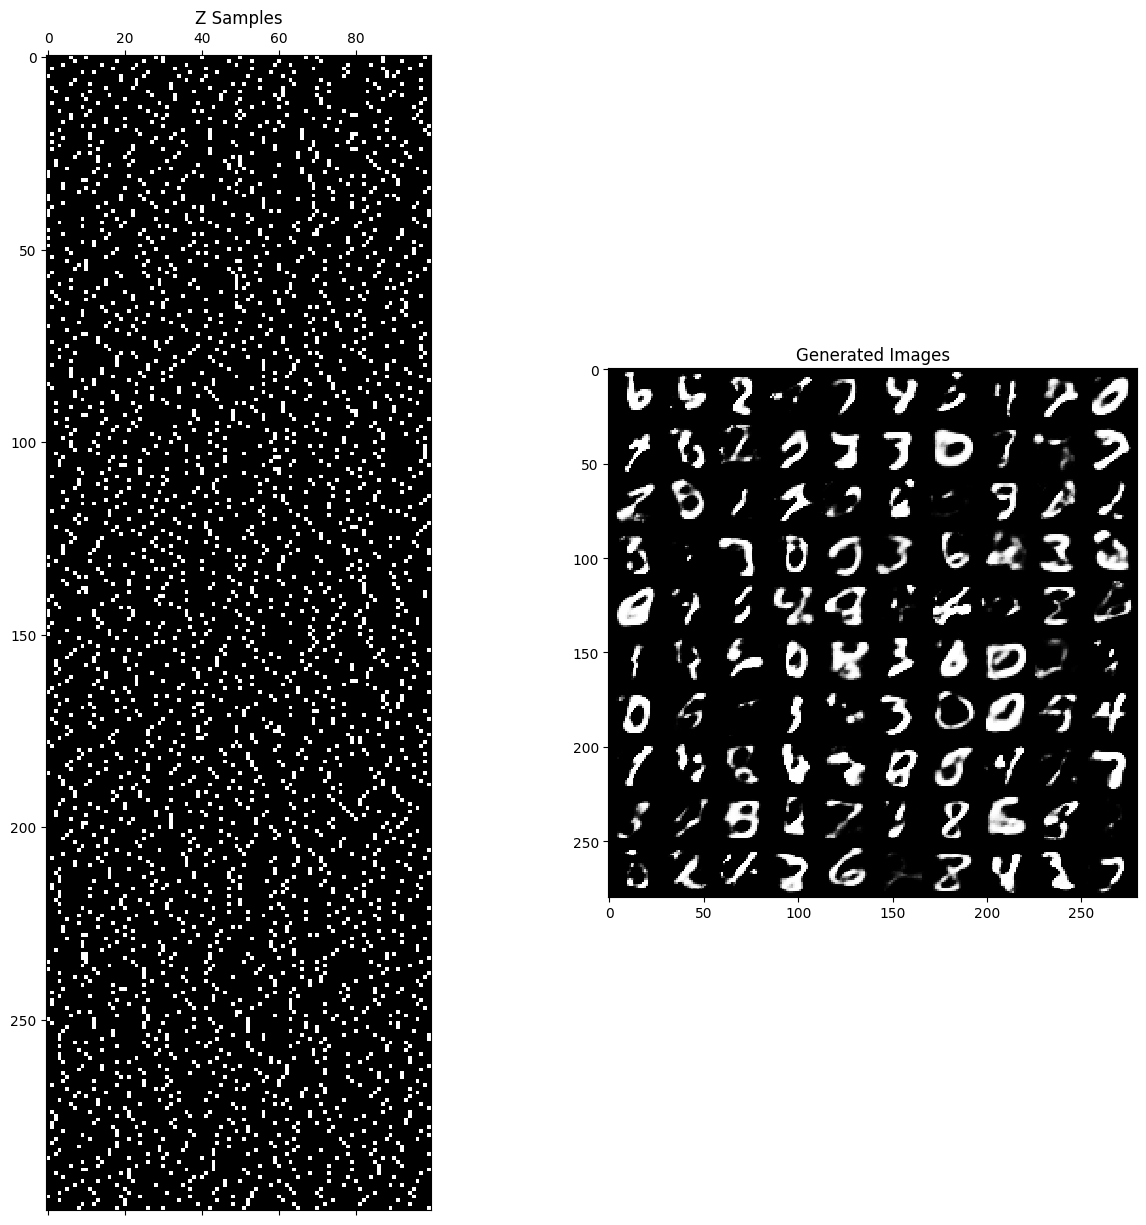

In [21]:
f,axarr=plt.subplots(1,2,figsize=(15,15))
# samples
axarr[0].matshow(y_img,cmap=plt.cm.gray)
axarr[0].set_title('Z Samples')
# reconstruction
axarr[1].imshow(x_img,cmap=plt.cm.gray,interpolation='none')
axarr[1].set_title('Generated Images')

In [22]:
f.tight_layout()
f.savefig('./code.png')